In [45]:
import numpy as np
import keras
from keras.datasets import mnist
from keras.utils import to_categorical
import keras.backend as K
from keras import layers
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from keras.preprocessing.image import ImageDataGenerator
import matplotlib
import pylab

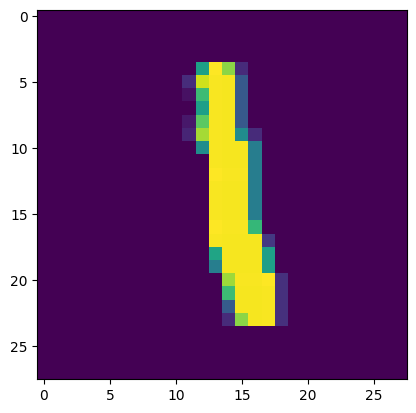

x_shape:  (60000, 28, 28)
y_shape:  (60000,)
x_test_shape:  (10000, 28, 28)
y_test_shape:  (10000,)


In [46]:
# 加载并预处理数据集
path = r'D:\contrastive-learning\Contrastive-learning-MNIST-main\mnist.npz'
(x_train, y_train), (x_test, y_test) = mnist.load_data(path)

# 将像素归一化0-1之间
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

#展示mnist数据集
im = x_train[6] #train中的第六张图
im = im.reshape(-1,28)
pylab.imshow(im)
pylab.show()

print('x_shape: ',x_train.shape)    # (60000, 28, 28)
print('y_shape: ',y_train.shape)    # (60000,)
print('x_test_shape: ',x_test.shape) # (10000, 28, 28)
print('y_test_shape: ',y_test.shape) #  (10000,)

In [47]:
# 定义数据增强器
data_augmentation = ImageDataGenerator(
    rotation_range=20,  # 随机旋转角度范围
    width_shift_range=0.2,  # 随机水平平移范围
    height_shift_range=0.2,  # 随机竖直平移范围
    shear_range=0.2,  # 随机剪切变换范围
    zoom_range=0.2,  # 随机缩放范围
    horizontal_flip=True,  # 随机水平翻转
    vertical_flip=True,  # 随机竖直翻转
    fill_mode='nearest'  # 填充模式
)

In [65]:
# 定义损失函数
# 写成闭包是为了传递alpha的值
def contrastive_loss(alpha):
    """
    :param alpha:表示anchor和negative之间为多少时认为他们不匹配
    """

    def loss(y_true, y_pred):
        anchor, positive, negative = y_pred[:, 0], y_pred[:, 1], y_pred[:, 2]
        # 计算欧式距离
        # K.sqrt(K.sum(K.square(a - b), axis=-1, keepdims=True))
        pos_distance = K.sqrt(K.sum(K.square(anchor - positive), axis=-1))
        neg_distance = K.sqrt(K.sum(K.square(anchor - negative), axis=-1))
        return K.mean((1 - y_true) * K.square(pos_distance) +
                      y_true * K.square(K.maximum(0.0, alpha - neg_distance)))

    return loss



In [49]:

# 自定义DataGenerator
class DataGenerator(keras.utils.Sequence):
    def __init__(self, x, y, batch_size, num_classes, alpha, data_augmentation):
        self.x = x
        self.y = y
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.alpha = alpha
        self.data_augmentation = data_augmentation  # 数据增强器

    def __len__(self):
        return int(np.ceil(len(self.x)) / float(self.batch_size))

    def __getitem__(self, index):
        batch_x = self.x[index * self.batch_size: (index + 1) * self.batch_size]
        batch_y = self.y[index * self.batch_size: (index + 1) * self.batch_size]
        anchor = batch_x
        # 通过对锚点数据进行数据增强生成正样本
        positive = self.data_augmentation.flow(anchor, shuffle=False, batch_size=self.batch_size).next()
        negative = np.zeros_like(anchor)

        for i in range(self.batch_size):
            neg_idx = np.random.choice(np.where(self.y != batch_y[i])[0])
            negative[i] = self.x[neg_idx]

        return [anchor, positive, negative], np.zeros((self.batch_size,))


In [66]:
# 定义超参数
num_classes = 10  # 类别数
input_shape = (28, 28, 1)  # 输入形状
batch_size = 128  # 批量大小
epochs = 20  # 轮次
embedding_dim = 64  # 嵌入维度
alpha = 0.1
# 构建模型并训练
anchor_input = layers.Input(shape=input_shape, name="anchor_input")
positive_input = layers.Input(shape=input_shape, name="positive_input")
negative_input = layers.Input(shape=input_shape, name="negative_input")

# 建立编码器
encoder = keras.Sequential(
    [
        layers.Conv2D(32, (3, 3), activation="relu", input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(embedding_dim, activation="relu"),
    ],
    name="encoder",
)

# 将锚点，正样本，负样本传入编码器
encoded_anchor = encoder(anchor_input)
encoded_positive = encoder(positive_input)
encoded_negative = encoder(negative_input)

merged_output = layers.concatenate([encoded_anchor, encoded_positive, encoded_negative], axis=-1, name="merged_layer")
model = keras.Model(inputs=[anchor_input, positive_input, negative_input], outputs=merged_output, name="triplet_model")

generator = DataGenerator(x_train.reshape(-1, 28, 28, 1), y_train, batch_size, num_classes, alpha, data_augmentation)

model.summary()#观察神经网络的参数

Model: "triplet_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 anchor_input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 positive_input (InputLayer)    [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 negative_input (InputLayer)    [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 encoder (Sequential)           (None, 64)           121280      ['anchor_input[0][0]',           
                                                                  'positive_input[0][0

In [67]:
# 训练模型
model.compile(loss=contrastive_loss(alpha), optimizer=Adam())
model.fit(generator, epochs=epochs)


Epoch 1/20
468/468 [==============================] - 55s 115ms/step - loss: 1.8258e-05
Epoch 2/20
468/468 [==============================] - 58s 124ms/step - loss: 0.0000e+00
Epoch 3/20
468/468 [==============================] - 58s 125ms/step - loss: 0.0000e+00
Epoch 4/20
468/468 [==============================] - 58s 124ms/step - loss: 0.0000e+00
Epoch 5/20
468/468 [==============================] - 60s 128ms/step - loss: 0.0000e+00
Epoch 6/20
468/468 [==============================] - 61s 130ms/step - loss: 0.0000e+00
Epoch 7/20
468/468 [==============================] - 65s 139ms/step - loss: 0.0000e+00
Epoch 8/20
468/468 [==============================] - 68s 146ms/step - loss: 0.0000e+00
Epoch 9/20
468/468 [==============================] - 66s 140ms/step - loss: 0.0000e+00
Epoch 10/20
468/468 [==============================] - 64s 137ms/step - loss: 0.0000e+00
Epoch 11/20
468/468 [==============================] - 65s 139ms/step - loss: 0.0000e+00
Epoch 12/20
468/468 [=========

313/313 [==============================] - 1s 3ms/step


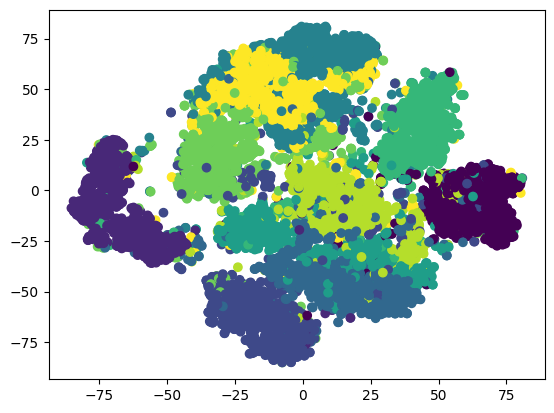

In [72]:

# 获取编码器
encoder = model.get_layer("encoder")
# 对测试数据进行编码生成向量
embeddings = encoder.predict(x_test.reshape(-1, 28, 28, 1))
# 使用t-SNE算法对向量进行降维
tsne_embeddings = TSNE(n_components=2).fit_transform(embeddings)
# TSNE可视化处理
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=y_test)
pylab.show()



In [73]:
x_train_encoded = encoder.predict(x_train.reshape(-1, 28, 28, 1))
x_test_encoded = encoder.predict(x_test.reshape(-1, 28, 28, 1))

# 训练MLP层并进行分类
mlp_model = keras.Sequential([
    layers.Dense(256, activation="relu", input_shape=(embedding_dim,)),
    layers.Dense(num_classes, activation="softmax")
], name="mlp_model")

# 编译并训练MLP
mlp_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
mlp_model.fit(x_train_encoded, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test_encoded, y_test))

test_loss, test_acc = mlp_model.evaluate(x_test_encoded, y_test)
print("Test accuracy:", test_acc)

313/313 [==============================] - 1s 4ms/step
Epoch 1/20
469/469 [==============================] - 1s 2ms/step - loss: 1.2461 - accuracy: 0.6805 - val_loss: 0.6780 - val_accuracy: 0.8121
Epoch 2/20
469/469 [==============================] - 1s 2ms/step - loss: 0.5935 - accuracy: 0.8236 - val_loss: 0.4981 - val_accuracy: 0.8512
Epoch 3/20
469/469 [==============================] - 1s 2ms/step - loss: 0.4851 - accuracy: 0.8508 - val_loss: 0.4413 - val_accuracy: 0.8617
Epoch 4/20
469/469 [==============================] - 1s 2ms/step - loss: 0.4364 - accuracy: 0.8651 - val_loss: 0.4002 - val_accuracy: 0.8769
Epoch 5/20
469/469 [==============================] - 1s 2ms/step - loss: 0.4057 - accuracy: 0.8731 - val_loss: 0.3792 - val_accuracy: 0.8824
Epoch 6/20
469/469 [==============================] - 1s 2ms/step - loss: 0.3824 - accuracy: 0.8811 - val_loss: 0.3609 - val_accuracy: 0.8890
Epoch 7/20
469/469 [==============================] - 1s 2ms/step - loss: 0.3647 - accuracy: 

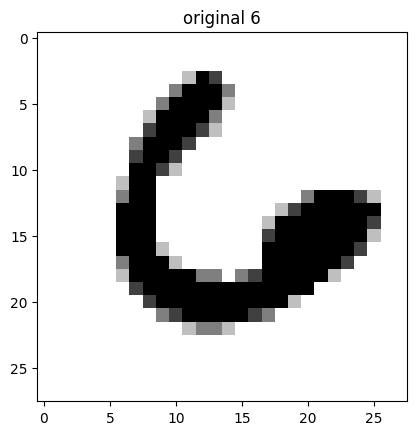

313/313 [==============================] - 0s 968us/step
index: 737
original: 6
predicted: 57332



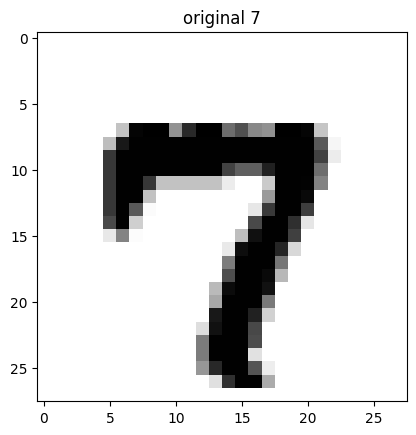

313/313 [==============================] - 0s 947us/step
index: 9393
original: 7
predicted: 57332



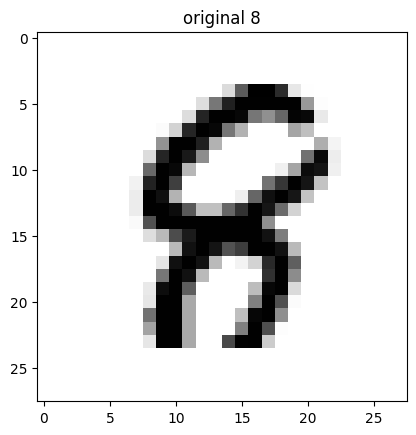

313/313 [==============================] - 0s 995us/step
index: 2800
original: 8
predicted: 57332



In [107]:

import random
import numpy as np
import matplotlib.pyplot as plt

while True:
    # 随机数
    index = random.randint(0, x_test.shape[0])
    x = x_test[index]
    y = y_test[index]

    # 显示该数字
    plt.imshow(x, cmap='gray_r')
    plt.title("original {}".format(y))
    plt.show()

    # 预测
    predict = mlp_model.predict(x_test_encoded)
    predict = np.argmax(predict)  # 取最大值的位置

    print('index:', index)
    print('original:', y)
    print('predicted:', predict)
    print()

    q = input('回车继续，q退出')
    if q == 'q':
        break

